# BDES analyzed with Bayesian logistic regression

In [1]:
%matplotlib inline

import glob

import numpy as np
import pandas as pd

import spectral_centroid as sc
import bayesian_logistic as bl

/usr/local/lib/python2.7/site-packages/librosa/core/audio.py:33: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


## Import BDES data

In [2]:
# Insert path to BDES here
base_path = ''

In [3]:
angry_paths = glob.glob(base_path + 'berlin/wav/*W*.wav')
sad_paths = glob.glob(base_path + 'berlin/wav/*T*.wav')

In [4]:
# Make sure we have all the files
assert len(angry_paths) == 127
assert len(sad_paths) == 62

In [5]:
speaker_ids = ['03', '08', '09', '10', '11', '12', '13', '14', '15', '16']

speaker_ids_long = []
emotions_long = []

speaker_angry_scs = []
speaker_sad_scs = []
speaker_all_scs_normed = []

for speaker in speaker_ids:
    sp_angry_paths = glob.glob(base_path + 'berlin/wav/{0}*W*.wav'.format(speaker))
    sp_sad_paths = glob.glob(base_path + 'berlin/wav/{0}*T*.wav'.format(speaker))
    
    speaker_ids_long += [speaker] * (len(sp_angry_paths) + len(sp_sad_paths))
    emotions_long += (['Angry'] * len(sp_angry_paths)) + (['Sad'] * len(sp_sad_paths))
    
    this_speaker_angry_scs = map(sc.mean_sc_for_file, sp_angry_paths)
    this_speaker_sad_scs = map(sc.mean_sc_for_file, sp_sad_paths)
    speaker_angry_scs += this_speaker_angry_scs
    speaker_sad_scs += this_speaker_sad_scs
    speaker_all_scs = this_speaker_angry_scs + this_speaker_sad_scs
    speaker_all_scs_normed += list((np.array(speaker_all_scs) - np.mean(speaker_all_scs)) / np.std(speaker_all_scs))

In [6]:
df_sp = pd.DataFrame({
        'Speaker ID': speaker_ids_long,
        'Mean SC': speaker_angry_scs + speaker_sad_scs,
        'Speaker-Standardized Mean SC': speaker_all_scs_normed,
        'Emotion': emotions_long
    })
df_sp['Angry'] = df_sp['Emotion'] == 'Angry'

In [7]:
df_sp.iloc[0:3]

,Emotion,Mean SC,Speaker ID,Speaker-Standardized Mean SC,Angry
0,Angry,1805.778053,03,0.313110,True
1,Angry,2207.691773,03,1.415638,True
2,Angry,1798.123843,03,0.292113,True


## Run Bayesian logistic regression

In [8]:
reload(bl);

In [9]:
X = df_sp['Speaker-Standardized Mean SC'].values
y = df_sp['Angry'].values

In [10]:
my_bl_cv = bl.BayesianLogisticClassifierCV(X, y, n_folds=5, n_iter=5000, n_chains=4)

In [11]:
my_bl_cv.fit()

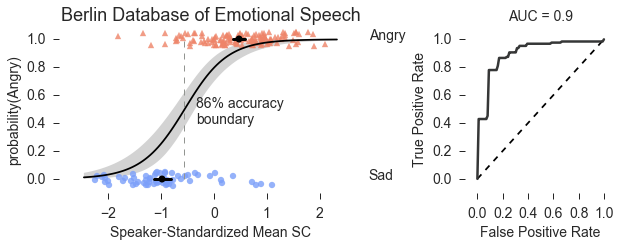

In [13]:
my_bl_cv.plot_all(
    true_cat="Angry", 
    false_cat="Sad",
    title="Berlin Database of Emotional Speech",
    reg_x_label="Speaker-Standardized Mean SC",
    reg_y_label="probability(Angry)",
    discriminant_label_offset=[0.05, 0.4],
)